<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices:", *tf.config.list_logical_devices('TPU'), sep='\n\t')

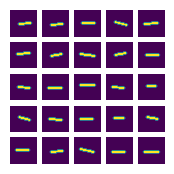

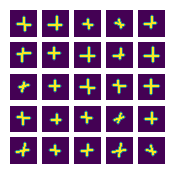

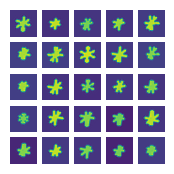

In [2]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='*'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #4885

X_text: "24-42" = y_text: "-18"


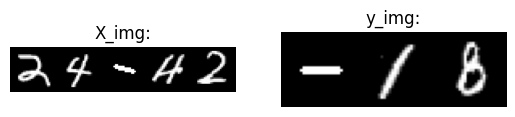

Query #266

X_text: "1+33 " = y_text: "34 "


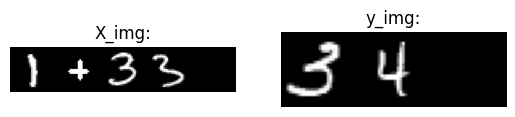

Query #2811

X_text: "14-5 " = y_text: "9  "


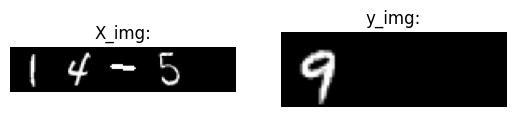

Query #1188

X_text: "5+94 " = y_text: "99 "


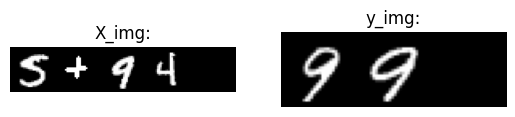

Query #2491

X_text: "12-45" = y_text: "-33"


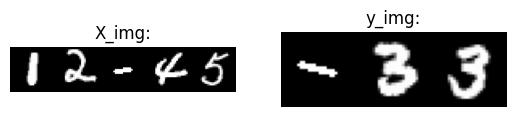

Query #486

X_text: "2+43 " = y_text: "45 "


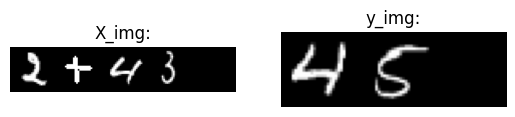

Query #9664

X_text: "48+32" = y_text: "80 "


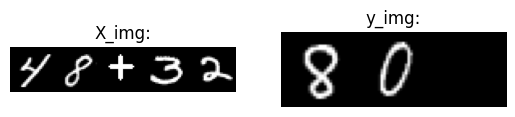

Query #3118

X_text: "15+59" = y_text: "74 "


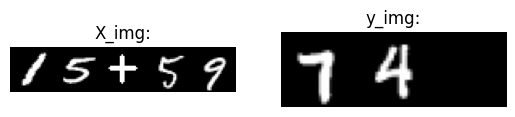

Query #1536

X_text: "7+68 " = y_text: "75 "


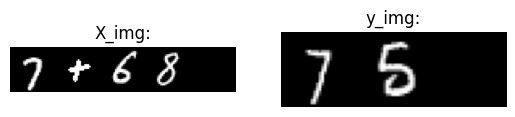

Query #9497

X_text: "47-48" = y_text: "-1 "


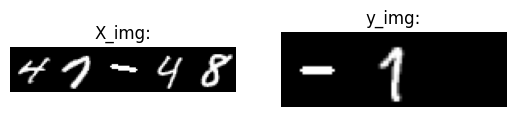

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)
print(X_text_onehot[0], decode_labels(X_text_onehot[0]), y_text_onehot[0], decode_labels(y_text_onehot[0]), sep='\n')

(20000, 5, 13) (20000, 3, 13)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
0+0  
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
0  


10+1  11 


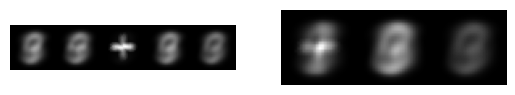

In [6]:
print(decode_labels(X_text_onehot.mean(axis=0)), decode_labels(y_text_onehot.mean(axis=0)))
for i, img in enumerate([X_img, y_img]):
    plt.subplot(1, 2, i+1)
    plt.axis('off')
    plt.imshow(np.hstack(img.mean(axis=0)), cmap='gray')

---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model(show_summary: bool = False, metrics = ["accuracy"]):

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    if show_summary:
        text2text.summary()

    return text2text

In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
# T2T = build_text2text_model()

# split = 0.9

# X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, train_size=split)

# T2T.fit(X_train, y_train, batch_size=256, validation_split=0.1, epochs=20, verbose=0)

# T2T.evaluate(X_test, y_test)





In [ ]:
fit_kwargs = {
    'batch_size': 32,
    'validation_split': 0.1,
    'epochs': 20,
}

def format_metrics(metrics):
    format  = '| split | training loss | training '
    format += ' | training '.join(metrics)
    format += ' | testing loss | testing '
    format += ' | testing '.join(metrics)
    format += ' | time |\n'
    format += f"| {' | '.join(['-'] * (2*len(metrics) + 4))} |"
    return format

def format_score(score, decimals=4):
    rounded = np.round(score, decimals)
    return ' | '.join(map(str, rounded))

def gen_splits(N: int):
    return [i/N for i in range(N)]

def test_splits(splits: list[int],
                model_name: str = ['T2T', 'I2T', 'T2I'],
                fit_kwargs: dict = {'batch_size': 32, 'validation_split': 0.1},
                metrics: list = ['accuracy', 'mse'],
                md_output: bool = False):
    if md_output:
        print(format_metrics(metrics))

    for split in splits:
        now = time.time()
        match model_name:
            case 'T2T':
                model = build_text2text_model(metrics = metrics)
                inputs = X_text_onehot
                outputs = y_text_onehot
            case 'I2T':
                model = build_img2text_model(metrics = metrics)
                inputs = X_img
                outputs = y_text_onehot
            case 'T2I':
                model = build_text2img_model(metrics = metrics)
                inputs = X_text_onehot
                outputs = y_img
            case _:
                raise Exception('Unsupported model provided')
        train_score = [np.nan]*(len(metrics)+1)
        test_score = [np.nan]*(len(metrics)+1)

        if split == 0: # edgecase where there is no training data
            X_test = inputs
            y_test = outputs
        elif split == 1: # edgecase where there is no testing data
            X_train = inputs
            y_train = outputs
        else:
            X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, train_size=float(split))

        if 0 < split <= 1: # fit the model as long as the split is greater than 0
            model.fit(X_train, y_train, **fit_kwargs, verbose=0)
            train_score = model.evaluate(X_train, y_train, verbose=0)

        if 0 <= split < 1: # evaluate unless there is no testing data
            test_score = model.evaluate(X_test, y_test, verbose=0)

        if md_output:
            print(f"| {split} | {format_score(train_score)} | {format_score(test_score)} | {time.time()-now:.3f} |")

In [ ]:
# T2T model over splits, results in table below
# test_splits([i/50 for i in range(50)], X_text_onehot, y_text_onehot, 'T2T', fit_kwargs, md_output=True)

| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 2.5651 | 0.0654 | 0.071 | 7.628 |
| 0.02 | 2.061 | 0.3342 | 0.0613 | 2.116 | 0.3291 | 0.0626 | 15.998 |
| 0.04 | 1.9442 | 0.3892 | 0.0577 | 1.9749 | 0.3857 | 0.0583 | 17.352 |
| 0.06 | 1.778 | 0.4081 | 0.0528 | 1.8094 | 0.4041 | 0.0535 | 17.532 |
| 0.08 | 1.6922 | 0.4127 | 0.0509 | 1.7291 | 0.3995 | 0.0516 | 19.940 |
| 0.1 | 1.7074 | 0.4063 | 0.0507 | 1.7334 | 0.3997 | 0.0513 | 21.939 |
| 0.12 | 1.5803 | 0.4276 | 0.048 | 1.6081 | 0.4158 | 0.0485 | 23.949 |
| 0.14 | 1.5378 | 0.451 | 0.047 | 1.5706 | 0.4349 | 0.0476 | 25.113 |
| 0.16 | 1.5323 | 0.4561 | 0.0471 | 1.5567 | 0.4452 | 0.0474 | 28.297 |
| 0.18 | 1.4327 | 0.4844 | 0.0445 | 1.4626 | 0.465 | 0.0451 | 29.558 |
| 0.2 | 1.4534 | 0.4746 | 0.0452 | 1.4745 | 0.4682 | 0.0457 | 30.557 |
| 0.22 | 1.3581 | 0.5217 | 0.0425 | 1.3765 | 0.5084 | 0.043 | 32.126 |
| 0.24 | 1.3547 | 0.5087 | 0.0428 | 1.3856 | 0.4961 | 0.0434 | 33.988 |
| 0.26 | 1.3385 | 0.5123 | 0.0424 | 1.3655 | 0.5037 | 0.0428 | 36.207 |
| 0.28 | 1.2985 | 0.5327 | 0.0414 | 1.3164 | 0.5214 | 0.0418 | 38.326 |
| 0.3 | 1.2982 | 0.5423 | 0.0416 | 1.3262 | 0.5261 | 0.0421 | 38.753 |
| 0.32 | 1.2592 | 0.5547 | 0.0403 | 1.2777 | 0.5443 | 0.0407 | 41.046 |
| 0.34 | 1.2238 | 0.5607 | 0.0393 | 1.2392 | 0.5497 | 0.0396 | 43.313 |
| 0.36 | 1.2196 | 0.5713 | 0.0392 | 1.238 | 0.5564 | 0.0396 | 44.655 |
| 0.38 | 1.204 | 0.5694 | 0.0387 | 1.221 | 0.5583 | 0.0391 | 45.569 |
| 0.4 | 1.1896 | 0.5882 | 0.0381 | 1.2058 | 0.5826 | 0.0384 | 48.460 |
| 0.42 | 1.1767 | 0.5807 | 0.0377 | 1.2008 | 0.5678 | 0.0383 | 51.143 |
| 0.44 | 1.2421 | 0.5504 | 0.0406 | 1.2577 | 0.5396 | 0.0408 | 51.661 |
| 0.46 | 1.1451 | 0.5904 | 0.037 | 1.1656 | 0.5801 | 0.0375 | 53.884 |
| 0.48 | 1.2091 | 0.5565 | 0.0395 | 1.2256 | 0.5494 | 0.0399 | 55.022 |
| 0.5 | 1.1086 | 0.6039 | 0.0358 | 1.1269 | 0.5921 | 0.0363 | 56.268 |
| 0.52 | 1.1257 | 0.602 | 0.0363 | 1.1502 | 0.5875 | 0.0369 | 61.128 |
| 0.54 | 1.0911 | 0.6138 | 0.0351 | 1.1035 | 0.6023 | 0.0354 | 61.010 |
| 0.56 | 1.103 | 0.6064 | 0.0357 | 1.1213 | 0.5954 | 0.0361 | 61.943 |
| 0.58 | 1.0916 | 0.6105 | 0.0352 | 1.1104 | 0.5999 | 0.0357 | 63.568 |
| 0.6 | 1.1203 | 0.6016 | 0.0362 | 1.1273 | 0.5955 | 0.0362 | 66.673 |
| 0.62 | 1.0758 | 0.6094 | 0.0349 | 1.0897 | 0.6021 | 0.0352 | 67.289 |
| 0.64 | 1.0551 | 0.622 | 0.034 | 1.0746 | 0.6103 | 0.0345 | 68.645 |
| 0.66 | 1.1009 | 0.5992 | 0.0362 | 1.1201 | 0.5875 | 0.0367 | 70.295 |
| 0.68 | 1.0489 | 0.6201 | 0.0342 | 1.0683 | 0.6061 | 0.0347 | 74.444 |
| 0.7 | 1.0199 | 0.6338 | 0.0328 | 1.0435 | 0.6192 | 0.0336 | 74.890 |
| 0.72 | 1.0208 | 0.6367 | 0.033 | 1.0344 | 0.6261 | 0.0333 | 75.151 |
| 0.74 | 1.2603 | 0.545 | 0.041 | 1.2782 | 0.5431 | 0.0412 | 79.038 |
| 0.76 | 1.0208 | 0.6247 | 0.0333 | 1.0421 | 0.6111 | 0.0339 | 80.669 |
| 0.78 | 1.0352 | 0.6273 | 0.0336 | 1.0463 | 0.618 | 0.0337 | 81.803 |
| 0.8 | 1.0189 | 0.6289 | 0.0331 | 1.0352 | 0.6233 | 0.0334 | 85.019 |
| 0.82 | 0.9838 | 0.6367 | 0.0319 | 1.002 | 0.6296 | 0.0323 | 84.593 |
| 0.84 | 1.1054 | 0.6097 | 0.0357 | 1.1327 | 0.597 | 0.0364 | 87.112 |
| 0.86 | 0.9759 | 0.647 | 0.0314 | 0.9897 | 0.6386 | 0.0317 | 90.649 |
| 0.88 | 1.0179 | 0.6238 | 0.0336 | 1.0322 | 0.614 | 0.0339 | 90.419 |
| 0.9 | 1.107 | 0.5949 | 0.0361 | 1.1396 | 0.5805 | 0.0368 | 92.757 |
| 0.92 | 1.0049 | 0.6264 | 0.0331 | 1.0127 | 0.6252 | 0.033 | 93.917 |
| 0.94 | 0.9777 | 0.6388 | 0.0319 | 0.9911 | 0.6314 | 0.0322 | 97.709 |
| 0.96 | 0.9613 | 0.6482 | 0.0314 | 0.9719 | 0.6371 | 0.0317 | 97.252 |
| 0.98 | 0.9444 | 0.662 | 0.0308 | 0.9699 | 0.6467 | 0.0314 | 99.168 |

| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 2.565 | 0.0509 | 0.071 | 7.409 |
| 0.1 | 1.7229 | 0.3957 | 0.0516 | 1.7563 | 0.3905 | 0.0523 | 25.286 |
| 0.2 | 1.516 | 0.4644 | 0.0468 | 1.5299 | 0.4584 | 0.0469 | 30.865 |
| 0.3 | 1.3377 | 0.5039 | 0.0429 | 1.3555 | 0.4919 | 0.0433 | 39.903 |
| 0.4 | 1.1774 | 0.5907 | 0.0377 | 1.2027 | 0.5786 | 0.0383 | 47.878 |
| 0.5 | 1.1637 | 0.5733 | 0.0378 | 1.181 | 0.5662 | 0.0382 | 56.584 |
| 0.6 | 1.0832 | 0.6049 | 0.0353 | 1.1074 | 0.5907 | 0.036 | 67.838 |
| 0.7 | 1.0651 | 0.6166 | 0.0345 | 1.0792 | 0.6082 | 0.0349 | 75.141 |
| 0.8 | 1.0079 | 0.6322 | 0.0327 | 1.0154 | 0.6259 | 0.0328 | 83.877 |
| 0.9 | 0.9524 | 0.6577 | 0.0307 | 0.9671 | 0.648 | 0.0311 | 93.216 |

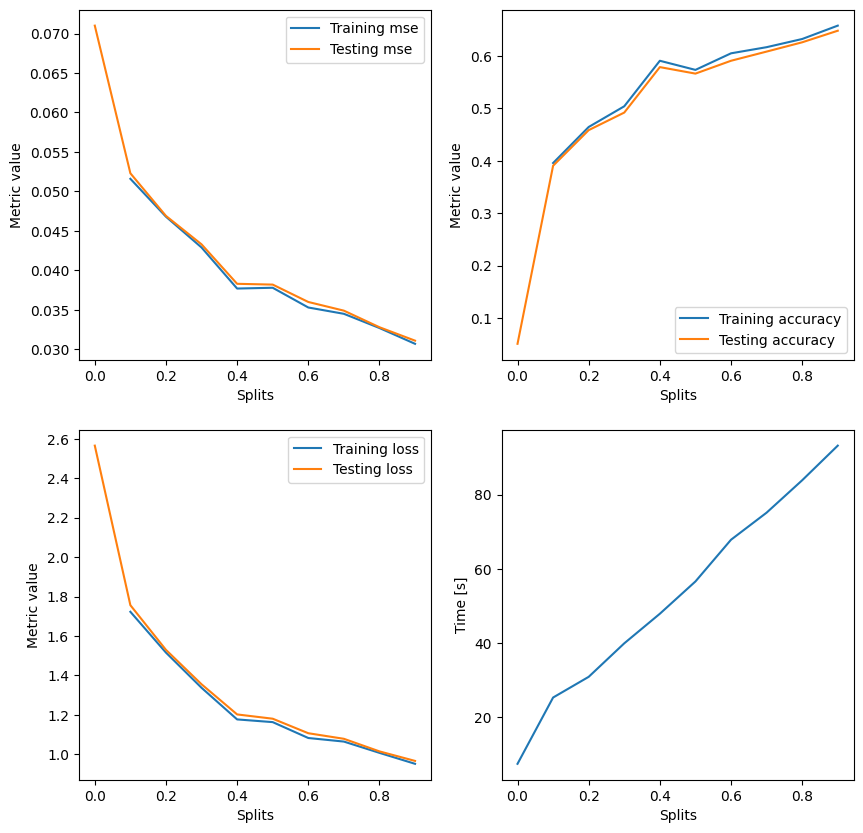

In [ ]:
data = np.array([
    [0.0, np.nan,  np.nan,  np.nan,  2.565 , 0.0509, 0.071 , 7.409 ],
    [0.1, 1.7229,  0.3957,  0.0516,  1.7563, 0.3905, 0.0523, 25.286],
    [0.2, 1.516 ,  0.4644,  0.0468,  1.5299, 0.4584, 0.0469, 30.865],
    [0.3, 1.3377,  0.5039,  0.0429,  1.3555, 0.4919, 0.0433, 39.903],
    [0.4, 1.1774,  0.5907,  0.0377,  1.2027, 0.5786, 0.0383, 47.878],
    [0.5, 1.1637,  0.5733,  0.0378,  1.181 , 0.5662, 0.0382, 56.584],
    [0.6, 1.0832,  0.6049,  0.0353,  1.1074, 0.5907, 0.036 , 67.838],
    [0.7, 1.0651,  0.6166,  0.0345,  1.0792, 0.6082, 0.0349, 75.141],
    [0.8, 1.0079,  0.6322,  0.0327,  1.0154, 0.6259, 0.0328, 83.877],
    [0.9, 0.9524,  0.6577,  0.0307,  0.9671, 0.648 , 0.0311, 93.216],
]).T

fig, ((mse_plot, acc_plot), (loss_plot, time_plot)) = plt.subplots(2, 2, figsize=(10,10))
mse_plot.plot(data[0], data[3], label='Training mse')
mse_plot.plot(data[0], data[6], label='Testing mse')
mse_plot.set_xlabel('Splits')
mse_plot.set_ylabel('Metric value')
mse_plot.legend()
acc_plot.plot(data[0], data[2], label='Training accuracy')
acc_plot.plot(data[0], data[5], label='Testing accuracy')
acc_plot.set_xlabel('Splits')
acc_plot.set_ylabel('Metric value')
acc_plot.legend()
loss_plot.plot(data[0], data[1], label='Training loss')
loss_plot.plot(data[0], data[4], label='Testing loss')
loss_plot.set_xlabel('Splits')
loss_plot.set_ylabel('Metric value')
loss_plot.legend()
time_plot.plot(data[0], data[7])
time_plot.set_xlabel('Splits')
time_plot.set_ylabel('Time [s]')

plt.show()

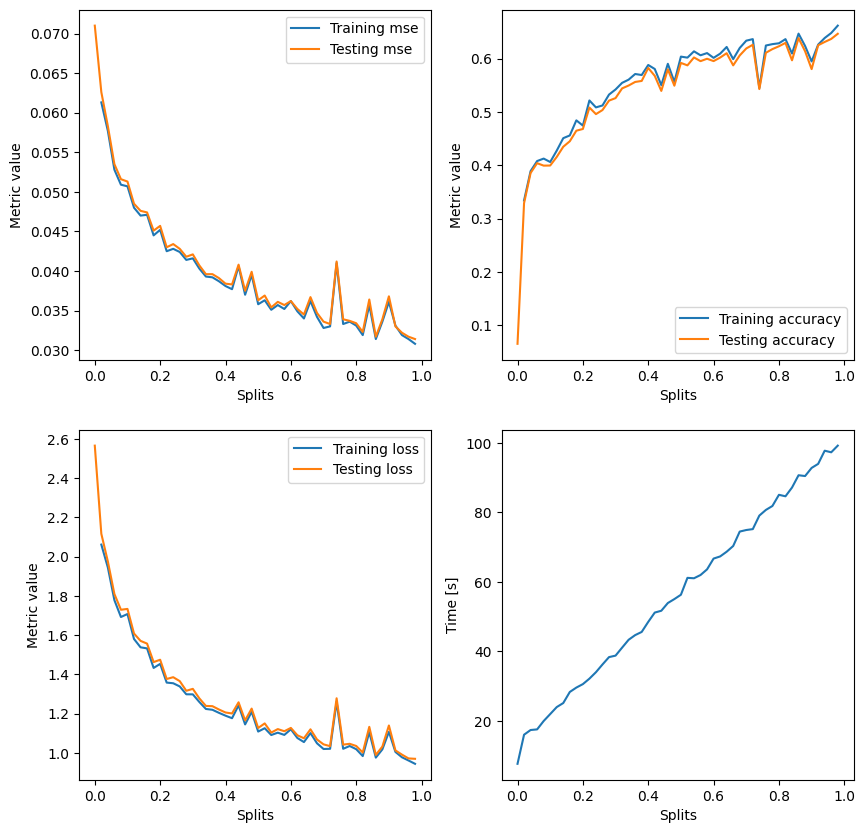

In [ ]:

data = np.array([
[0.0, 	np.nan, 	np.nan, 	np.nan, 	2.5651, 	0.0654, 	0.071, 	7.628],
[0.02, 	2.061, 	0.3342, 	0.0613, 	2.116, 	0.3291, 	0.0626, 	15.998],
[0.04, 	1.9442, 	0.3892, 	0.0577, 	1.9749, 	0.3857, 	0.0583, 	17.352],
[0.06, 	1.778, 	0.4081, 	0.0528, 	1.8094, 	0.4041, 	0.0535, 	17.532],
[0.08, 	1.6922, 	0.4127, 	0.0509, 	1.7291, 	0.3995, 	0.0516, 	19.940],
[0.1, 	1.7074, 	0.4063, 	0.0507, 	1.7334, 	0.3997, 	0.0513, 	21.939],
[0.12, 	1.5803, 	0.4276, 	0.048, 	1.6081, 	0.4158, 	0.0485, 	23.949],
[0.14, 	1.5378, 	0.451, 	0.047, 	1.5706, 	0.4349, 	0.0476, 	25.113],
[0.16, 	1.5323, 	0.4561, 	0.0471, 	1.5567, 	0.4452, 	0.0474, 	28.297],
[0.18, 	1.4327, 	0.4844, 	0.0445, 	1.4626, 	0.465, 	0.0451, 	29.558],
[0.2, 	1.4534, 	0.4746, 	0.0452, 	1.4745, 	0.4682, 	0.0457, 	30.557],
[0.22, 	1.3581, 	0.5217, 	0.0425, 	1.3765, 	0.5084, 	0.043, 	32.126],
[0.24, 	1.3547, 	0.5087, 	0.0428, 	1.3856, 	0.4961, 	0.0434, 	33.988],
[0.26, 	1.3385, 	0.5123, 	0.0424, 	1.3655, 	0.5037, 	0.0428, 	36.207],
[0.28, 	1.2985, 	0.5327, 	0.0414, 	1.3164, 	0.5214, 	0.0418, 	38.326],
[0.3, 	1.2982, 	0.5423, 	0.0416, 	1.3262, 	0.5261, 	0.0421, 	38.753],
[0.32, 	1.2592, 	0.5547, 	0.0403, 	1.2777, 	0.5443, 	0.0407, 	41.046],
[0.34, 	1.2238, 	0.5607, 	0.0393, 	1.2392, 	0.5497, 	0.0396, 	43.313],
[0.36, 	1.2196, 	0.5713, 	0.0392, 	1.238, 	0.5564, 	0.0396, 	44.655],
[0.38, 	1.204, 	0.5694, 	0.0387, 	1.221, 	0.5583, 	0.0391, 	45.569],
[0.4, 	1.1896, 	0.5882, 	0.0381, 	1.2058, 	0.5826, 	0.0384, 	48.460],
[0.42, 	1.1767, 	0.5807, 	0.0377, 	1.2008, 	0.5678, 	0.0383, 	51.143],
[0.44, 	1.2421, 	0.5504, 	0.0406, 	1.2577, 	0.5396, 	0.0408, 	51.661],
[0.46, 	1.1451, 	0.5904, 	0.037, 	1.1656, 	0.5801, 	0.0375, 	53.884],
[0.48, 	1.2091, 	0.5565, 	0.0395, 	1.2256, 	0.5494, 	0.0399, 	55.022],
[0.5, 	1.1086, 	0.6039, 	0.0358, 	1.1269, 	0.5921, 	0.0363, 	56.268],
[0.52, 	1.1257, 	0.602, 	0.0363, 	1.1502, 	0.5875, 	0.0369, 	61.128],
[0.54, 	1.0911, 	0.6138, 	0.0351, 	1.1035, 	0.6023, 	0.0354, 	61.010],
[0.56, 	1.103, 	0.6064, 	0.0357, 	1.1213, 	0.5954, 	0.0361, 	61.943],
[0.58, 	1.0916, 	0.6105, 	0.0352, 	1.1104, 	0.5999, 	0.0357, 	63.568],
[0.6, 	1.1203, 	0.6016, 	0.0362, 	1.1273, 	0.5955, 	0.0362, 	66.673],
[0.62, 	1.0758, 	0.6094, 	0.0349, 	1.0897, 	0.6021, 	0.0352, 	67.289],
[0.64, 	1.0551, 	0.622, 	0.034, 	1.0746, 	0.6103, 	0.0345, 	68.645],
[0.66, 	1.1009, 	0.5992, 	0.0362, 	1.1201, 	0.5875, 	0.0367, 	70.295],
[0.68, 	1.0489, 	0.6201, 	0.0342, 	1.0683, 	0.6061, 	0.0347, 	74.444],
[0.7, 	1.0199, 	0.6338, 	0.0328, 	1.0435, 	0.6192, 	0.0336, 	74.890],
[0.72, 	1.0208, 	0.6367, 	0.033, 	1.0344, 	0.6261, 	0.0333, 	75.151],
[0.74, 	1.2603, 	0.545, 	0.041, 	1.2782, 	0.5431, 	0.0412, 	79.038],
[0.76, 	1.0208, 	0.6247, 	0.0333, 	1.0421, 	0.6111, 	0.0339, 	80.669],
[0.78, 	1.0352, 	0.6273, 	0.0336, 	1.0463, 	0.618, 	0.0337, 	81.803],
[0.8, 	1.0189, 	0.6289, 	0.0331, 	1.0352, 	0.6233, 	0.0334, 	85.019],
[0.82, 	0.9838, 	0.6367, 	0.0319, 	1.002, 	0.6296, 	0.0323, 	84.593],
[0.84, 	1.1054, 	0.6097, 	0.0357, 	1.1327, 	0.597, 	0.0364, 	87.112],
[0.86, 	0.9759, 	0.647, 	0.0314, 	0.9897, 	0.6386, 	0.0317, 	90.649],
[0.88, 	1.0179, 	0.6238, 	0.0336, 	1.0322, 	0.614, 	0.0339, 	90.419],
[0.9, 	1.107, 	0.5949, 	0.0361, 	1.1396, 	0.5805, 	0.0368, 	92.757],
[0.92, 	1.0049, 	0.6264, 	0.0331, 	1.0127, 	0.6252, 	0.033, 	93.917],
[0.94, 	0.9777, 	0.6388, 	0.0319, 	0.9911, 	0.6314, 	0.0322, 	97.709],
[0.96, 	0.9613, 	0.6482, 	0.0314, 	0.9719, 	0.6371, 	0.0317, 	97.252],
[0.98, 	0.9444, 	0.662, 	0.0308, 	0.9699, 	0.6467, 	0.0314, 	99.168],
]).T

fig, ((mse_plot, acc_plot), (loss_plot, time_plot)) = plt.subplots(2, 2, figsize=(10,10))
mse_plot.plot(data[0], data[3], label='Training mse')
mse_plot.plot(data[0], data[6], label='Testing mse')
mse_plot.set_xlabel('Splits')
mse_plot.set_ylabel('Metric value')
mse_plot.legend()
acc_plot.plot(data[0], data[2], label='Training accuracy')
acc_plot.plot(data[0], data[5], label='Testing accuracy')
acc_plot.set_xlabel('Splits')
acc_plot.set_ylabel('Metric value')
acc_plot.legend()
loss_plot.plot(data[0], data[1], label='Training loss')
loss_plot.plot(data[0], data[4], label='Testing loss')
loss_plot.set_xlabel('Splits')
loss_plot.set_ylabel('Metric value')
loss_plot.legend()
time_plot.plot(data[0], data[7])
time_plot.set_xlabel('Splits')
time_plot.set_ylabel('Time [s]')

plt.show()


---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
## Your code
def build_img2text_model(show_summary: bool = False, metrics = ["accuracy"]):
    # We start by initializing a sequential model
    img2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 28, 28] as we have queries of length 5 and 28x28 images. Each of these 5 elements in the query will be fed to the network one by one.
    # We reshape the input vector to be [5, 28*28]
    img2text.add(ConvLSTM2D(
        filters=16,
        kernel_size=7,
        input_shape=(None, 28, 28, 1) # time, nx, ny, filters
    ))
    img2text.add(MaxPooling2D())

    img2text.add(Conv2D(
        filters=32,
        kernel_size=5
    ))
    img2text.add(MaxPooling2D())
    img2text.add(Flatten())

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    if show_summary:
        img2text.summary()

    return img2text

# build_img2text_model(True)

# test_splits([i/10 for i in range(10)], X_img, y_text_onehot, 'I2T', fit_kwargs, md_output=True)


| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 2.5687 | 0.0637 | 0.0711 | 12.110 |
| 0.1 | 1.8277 | 0.3828 | 0.0554 | 2.0176 | 0.3419 | 0.0594 | 28.926 |
| 0.2 | 1.5185 | 0.4745 | 0.047 | 1.8433 | 0.3837 | 0.0539 | 40.106 |
| 0.3 | 1.2844 | 0.5551 | 0.0411 | 1.7809 | 0.4096 | 0.052 | 52.857 |
| 0.4 | 1.2627 | 0.5524 | 0.0406 | 1.7892 | 0.4133 | 0.0518 | 67.375 |
| 0.5 | 1.1492 | 0.6021 | 0.0377 | 1.7305 | 0.4402 | 0.0503 | 75.683 |
| 0.6 | 1.1423 | 0.6015 | 0.0374 | 1.7177 | 0.4427 | 0.0495 | 82.935 |
| 0.7 | 1.0388 | 0.6445 | 0.0344 | 1.7138 | 0.4594 | 0.0493 | 92.772 |
| 0.8 | 1.0468 | 0.6338 | 0.0347 | 1.7024 | 0.4667 | 0.0491 | 103.957 |
| 0.9 | 1.0117 | 0.65 | 0.0332 | 1.623 | 0.4817 | 0.0471 | 117.633 |

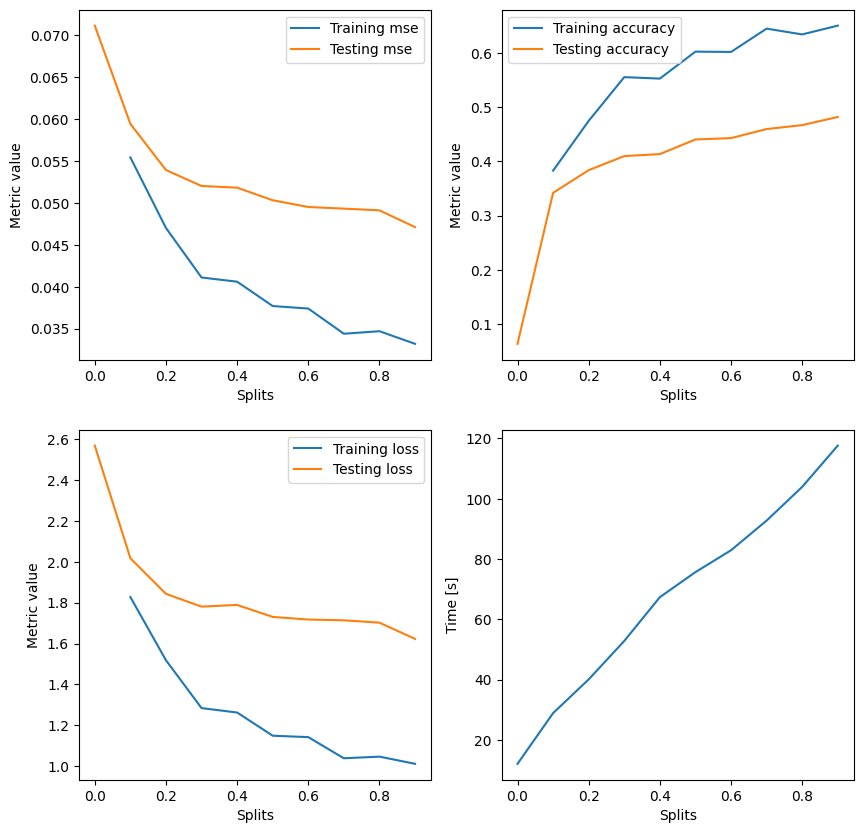

In [ ]:
data = np.array([
    [0.0, np.nan, np.nan, np.nan, 2.5687, 0.0637, 0.0711, 12.110],
    [0.1, 1.8277, 0.3828, 0.0554, 2.0176, 0.3419, 0.0594, 28.926],
    [0.2, 1.5185, 0.4745, 0.047 , 1.8433, 0.3837, 0.0539, 40.106],
    [0.3, 1.2844, 0.5551, 0.0411, 1.7809, 0.4096, 0.052 , 52.857],
    [0.4, 1.2627, 0.5524, 0.0406, 1.7892, 0.4133, 0.0518, 67.375],
    [0.5, 1.1492, 0.6021, 0.0377, 1.7305, 0.4402, 0.0503, 75.683],
    [0.6, 1.1423, 0.6015, 0.0374, 1.7177, 0.4427, 0.0495, 82.935],
    [0.7, 1.0388, 0.6445, 0.0344, 1.7138, 0.4594, 0.0493, 92.772],
    [0.8, 1.0468, 0.6338, 0.0347, 1.7024, 0.4667, 0.0491, 103.957],
    [0.9, 1.0117, 0.6500, 0.0332, 1.623 , 0.4817, 0.0471, 117.633],
]).T

fig, ((mse_plot, acc_plot), (loss_plot, time_plot)) = plt.subplots(2, 2, figsize=(10,10))
mse_plot.plot(data[0], data[3], label='Training mse')
mse_plot.plot(data[0], data[6], label='Testing mse')
mse_plot.set_xlabel('Splits')
mse_plot.set_ylabel('Metric value')
mse_plot.legend()
acc_plot.plot(data[0], data[2], label='Training accuracy')
acc_plot.plot(data[0], data[5], label='Testing accuracy')
acc_plot.set_xlabel('Splits')
acc_plot.set_ylabel('Metric value')
acc_plot.legend()
loss_plot.plot(data[0], data[1], label='Training loss')
loss_plot.plot(data[0], data[4], label='Testing loss')
loss_plot.set_xlabel('Splits')
loss_plot.set_ylabel('Metric value')
loss_plot.legend()
time_plot.plot(data[0], data[7])
time_plot.set_xlabel('Splits')
time_plot.set_ylabel('Time [s]')

plt.show()

| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 2.5581 | 0.1939 | 0.0709 | 18.088 |
| 0.1 | 1.9903 | 0.3642 | 0.0602 | 2.0217 | 0.3629 | 0.0607 | 116.405 |
| 0.2 | 1.7627 | 0.4149 | 0.0534 | 1.8315 | 0.3927 | 0.0549 | 205.386 |
| 0.3 | 1.6812 | 0.4306 | 0.0512 | 1.7954 | 0.3954 | 0.0538 | 299.649 |
| 0.4 | 1.5518 | 0.471 | 0.0482 | 1.7321 | 0.4126 | 0.0522 | 387.402 |
| 0.5 | 1.4533 | 0.5011 | 0.0457 | 1.7086 | 0.4162 | 0.0515 | 478.642 |
| 0.6 | 1.4463 | 0.5053 | 0.0456 | 1.6707 | 0.4219 | 0.0508 | 570.219 |
| 0.7 | 1.4038 | 0.5241 | 0.0445 | 1.6689 | 0.4348 | 0.0506 | 661.080 |
| 0.8 | 1.3384 | 0.5429 | 0.0428 | 1.6393 | 0.4338 | 0.0498 | 751.663 |
| 0.9 | 1.3331 | 0.5446 | 0.0427 | 1.6358 | 0.4428 | 0.0496 | 841.382 |

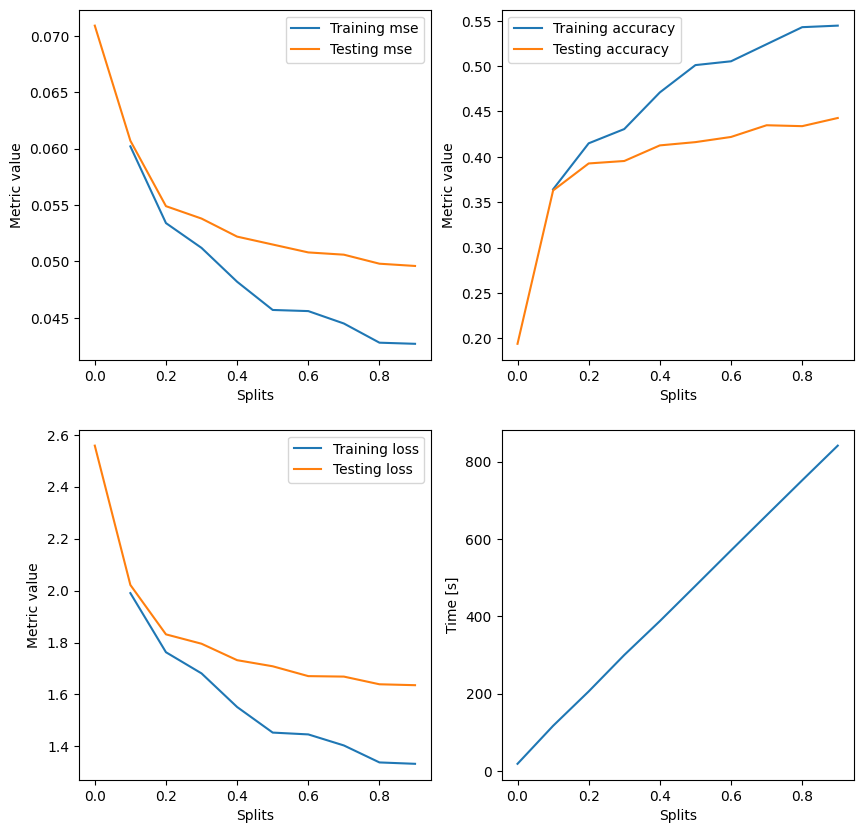

In [ ]:
data = np.array([
    [0.0, np.nan, np.nan, np.nan, 2.5581, 0.1939, 0.0709,  18.088],
    [0.1, 1.9903, 0.3642, 0.0602, 2.0217, 0.3629, 0.0607, 116.405],
    [0.2, 1.7627, 0.4149, 0.0534, 1.8315, 0.3927, 0.0549, 205.386],
    [0.3, 1.6812, 0.4306, 0.0512, 1.7954, 0.3954, 0.0538, 299.649],
    [0.4, 1.5518, 0.471 , 0.0482, 1.7321, 0.4126, 0.0522, 387.402],
    [0.5, 1.4533, 0.5011, 0.0457, 1.7086, 0.4162, 0.0515, 478.642],
    [0.6, 1.4463, 0.5053, 0.0456, 1.6707, 0.4219, 0.0508, 570.219],
    [0.7, 1.4038, 0.5241, 0.0445, 1.6689, 0.4348, 0.0506, 661.080],
    [0.8, 1.3384, 0.5429, 0.0428, 1.6393, 0.4338, 0.0498, 751.663],
    [0.9, 1.3331, 0.5446, 0.0427, 1.6358, 0.4428, 0.0496, 841.382],
]).T

fig, ((mse_plot, acc_plot), (loss_plot, time_plot)) = plt.subplots(2, 2, figsize=(10,10))
mse_plot.plot(data[0], data[3], label='Training mse')
mse_plot.plot(data[0], data[6], label='Testing mse')
mse_plot.set_xlabel('Splits')
mse_plot.set_ylabel('Metric value')
mse_plot.legend()
acc_plot.plot(data[0], data[2], label='Training accuracy')
acc_plot.plot(data[0], data[5], label='Testing accuracy')
acc_plot.set_xlabel('Splits')
acc_plot.set_ylabel('Metric value')
acc_plot.legend()
loss_plot.plot(data[0], data[1], label='Training loss')
loss_plot.plot(data[0], data[4], label='Testing loss')
loss_plot.set_xlabel('Splits')
loss_plot.set_ylabel('Metric value')
loss_plot.legend()
time_plot.plot(data[0], data[7])
time_plot.set_xlabel('Splits')
time_plot.set_ylabel('Time [s]')

plt.show()

---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [ ]:
# Your code
def build_text2img_model(show_summary: bool = False, metrics = ["accuracy"]):
    # We start by initializing a sequential model
    text2img = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    text2img.add(LSTM(9*9*4, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2img.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # # the first dimension to be the timesteps.
    text2img.add(LSTM(9*9*4, return_sequences=True))

    #Reshape the input, upscale to 32x32 and then downscale to 28x28 for the original image size.
    text2img.add(TimeDistributed(Reshape((9,9,4))))
    text2img.add(TimeDistributed(Conv2D(filters=32, kernel_size=3))) # changes dimensions to (7, 7, 32)
    text2img.add(TimeDistributed(Conv2DTranspose(32, 2, 2))) # changes dimensions to (14, 14, 32)
    text2img.add(TimeDistributed(Conv2DTranspose(64, 2, 2))) # changes dimensions to (28, 28, 64)
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(5,5), padding='same', activation='sigmoid'))) #changes dimensions back to 28x28x1
    text2img.add(TimeDistributed(Reshape((28,28))))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2img.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics, steps_per_execution=10)
    if show_summary:
        text2img.summary()

    return text2img

# build_text2img_model(True)
test_splits(gen_splits(10), 'T2I', fit_kwargs, md_output=True)





| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 0.6931 | 0.0255 | 0.2374 | 16.884 |
| 0.1 | 0.1895 | 0.0876 | 0.0483 | 0.1914 | 0.0867 | 0.0487 | 129.412 |
| 0.2 | 0.1837 | 0.0901 | 0.0468 | 0.186 | 0.0875 | 0.0473 | 227.715 |
| 0.3 | 0.1822 | 0.0905 | 0.0463 | 0.1834 | 0.0885 | 0.0466 | 326.669 |
| 0.4 | 0.1812 | 0.0958 | 0.046 | 0.1826 | 0.0936 | 0.0463 | 420.091 |
| 0.5 | 0.1796 | 0.1029 | 0.0456 | 0.1804 | 0.1005 | 0.0458 | 526.220 |
| 0.6 | 0.18 | 0.1034 | 0.0456 | 0.1808 | 0.1019 | 0.0459 | 628.136 |
| 0.7 | 0.1777 | 0.1104 | 0.045 | 0.1802 | 0.1106 | 0.0457 | 725.622 |
| 0.8 | 0.1784 | 0.1026 | 0.0452 | 0.1793 | 0.1011 | 0.0454 | 813.028 |
| 0.9 | 0.1758 | 0.1116 | 0.0445 | 0.1767 | 0.1095 | 0.0448 | 926.244 |


| split | training loss | training accuracy | training mse | testing loss | testing accuracy | testing mse | time |
| - | - | - | - | - | - | - | - |
| 0.0 | nan | nan | nan | 0.6931 | 0.0255 | 0.2374 | 16.884 |
| 0.1 | 0.1895 | 0.0876 | 0.0483 | 0.1914 | 0.0867 | 0.0487 | 129.412 |
| 0.2 | 0.1837 | 0.0901 | 0.0468 | 0.186 | 0.0875 | 0.0473 | 227.715 |
| 0.3 | 0.1822 | 0.0905 | 0.0463 | 0.1834 | 0.0885 | 0.0466 | 326.669 |
| 0.4 | 0.1812 | 0.0958 | 0.046 | 0.1826 | 0.0936 | 0.0463 | 420.091 |
| 0.5 | 0.1796 | 0.1029 | 0.0456 | 0.1804 | 0.1005 | 0.0458 | 526.220 |
| 0.6 | 0.18 | 0.1034 | 0.0456 | 0.1808 | 0.1019 | 0.0459 | 628.136 |
| 0.7 | 0.1777 | 0.1104 | 0.045 | 0.1802 | 0.1106 | 0.0457 | 725.622 |
| 0.8 | 0.1784 | 0.1026 | 0.0452 | 0.1793 | 0.1011 | 0.0454 | 813.028 |
| 0.9 | 0.1758 | 0.1116 | 0.0445 | 0.1767 | 0.1095 | 0.0448 | 926.244 |

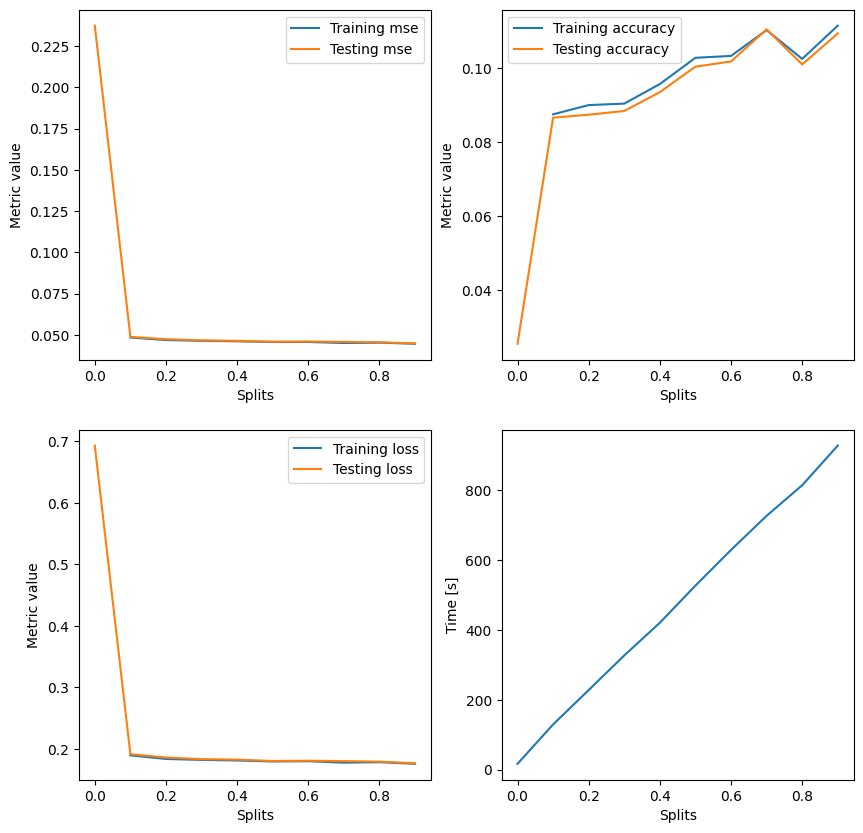

In [ ]:
data = np.array([
    [0.0, np.nan, np.nan, np.nan, 0.6931, 0.0255, 0.2374,  16.884],
    [0.1, 0.1895, 0.0876, 0.0483, 0.1914, 0.0867, 0.0487, 129.412],
    [0.2, 0.1837, 0.0901, 0.0468, 0.186 , 0.0875, 0.0473, 227.715],
    [0.3, 0.1822, 0.0905, 0.0463, 0.1834, 0.0885, 0.0466, 326.669],
    [0.4, 0.1812, 0.0958, 0.046 , 0.1826, 0.0936, 0.0463, 420.091],
    [0.5, 0.1796, 0.1029, 0.0456, 0.1804, 0.1005, 0.0458, 526.220],
    [0.6, 0.18  , 0.1034, 0.0456, 0.1808, 0.1019, 0.0459, 628.136],
    [0.7, 0.1777, 0.1104, 0.045 , 0.1802, 0.1106, 0.0457, 725.622],
    [0.8, 0.1784, 0.1026, 0.0452, 0.1793, 0.1011, 0.0454, 813.028],
    [0.9, 0.1758, 0.1116, 0.0445, 0.1767, 0.1095, 0.0448, 926.244],
]).T

fig, ((mse_plot, acc_plot), (loss_plot, time_plot)) = plt.subplots(2, 2, figsize=(10,10))
mse_plot.plot(data[0], data[3], label='Training mse')
mse_plot.plot(data[0], data[6], label='Testing mse')
mse_plot.set_xlabel('Splits')
mse_plot.set_ylabel('Metric value')
mse_plot.legend()
acc_plot.plot(data[0], data[2], label='Training accuracy')
acc_plot.plot(data[0], data[5], label='Testing accuracy')
acc_plot.set_xlabel('Splits')
acc_plot.set_ylabel('Metric value')
acc_plot.legend()
loss_plot.plot(data[0], data[1], label='Training loss')
loss_plot.plot(data[0], data[4], label='Testing loss')
loss_plot.set_xlabel('Splits')
loss_plot.set_ylabel('Metric value')
loss_plot.legend()
time_plot.plot(data[0], data[7])
time_plot.set_xlabel('Splits')
time_plot.set_ylabel('Time [s]')

plt.show()

In [18]:
def build_text2img_model_simple(
        loss_func: str = 'binary_crossentropy',
        activation: str = 'sigmoid',
        show_summary: bool = False,
        metrics = ["accuracy"],
        num_encode_layers: int = 1,
        num_decode_layers: int = 1
        ):
    # We start by initializing a sequential model
    text2img = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2img.add(LSTM(512, input_shape=(None, len(unique_characters)),return_sequences=False))

    # As the decoder RNN's input, repeatedly provide Part 1: Addition and subtractionith the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2img.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim).
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    for _ in range(num_decode_layers):
        text2img.add(LSTM(512, return_sequences=True))

    #Reshape the input, upscale to 32x32 and then downscale to 28x28 for the original image size.
    text2img.add(TimeDistributed(Reshape((8, 8, 8))))
    text2img.add(TimeDistributed(Conv2DTranspose(64, kernel_size=(2,2),strides=(2,2),padding='same'))) # changes dimensions to 16x16, no. filters I am really not sure what it should be, just picked something
    text2img.add(TimeDistributed(Dropout(0.2)))
    text2img.add(TimeDistributed(Conv2DTranspose(128, kernel_size=(2,2),strides=(2,2),padding='same'))) # changes dimensions to 32x32, no. filters I am really not sure what it should be, just picked something
    text2img.add(TimeDistributed(Dropout(0.2)))
    text2img.add(TimeDistributed(Conv2D(filters=64,kernel_size=(5,5)))) #changes dimensions back to 28x28x1
    text2img.add(TimeDistributed(Dropout(0.2)))
    text2img.add(TimeDistributed(Conv2D(filters=1,kernel_size=(1,1),padding='same', activation='sigmoid'))) #changes dimensions back to 28x28x1
    text2img.add(TimeDistributed(Dropout(0.2)))
    text2img.add(TimeDistributed(Reshape((28,28))))


    # Next we compile the model using categorical crossentropy as our loss function.
    text2img.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    if show_summary:
        text2img.summary()

    return text2img

In [10]:
X_train, X_test, y_train, y_test = train_test_split(y_img, y_text_onehot, train_size=0.8)

def evaluate_text2img(show_summary=False,
                      metrics = ['accuracy']):

    mod = tf.keras.Sequential()
    mod.add(Reshape((3,28*28), input_shape=(3,28,28)))
    # mod.add(RepeatVector(3))
    mod.add(Dense(364,activation='relu'))
    mod.add(BatchNormalization())
    mod.add(Dropout(0.5))

    mod.add(Dense(52,activation = 'relu'))
    mod.add(BatchNormalization())
    mod.add(Dropout(0.5))

    mod.add(Dense(len(unique_characters), activation='softmax'))

    mod.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

    if show_summary:
        mod.summary()

    return mod

mod = evaluate_text2img(True)
mod.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, verbose=0)
mod.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 784)            0         
                                                                 
 dense (Dense)               (None, 3, 364)            285740    
                                                                 
 batch_normalization (Batch  (None, 3, 364)            1456      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 364)            0         
                                                                 
 dense_1 (Dense)             (None, 3, 52)             18980     
                                                                 
 batch_normalization_1 (Bat  (None, 3, 52)             208       
 chNormalization)                                       

[0.047043196856975555, 0.9889166951179504]

In [30]:
for narch in [1]:
    model = build_text2img_model_simple(show_summary=True)

    fit_kwargs = {
        'batch_size': 128,
        'validation_split': 0.1,
        'epochs': 20,
    }

    metrics = ['accuracy']

    train_score = [np.nan]*(len(metrics)+1)
    test_score = [np.nan]*(len(metrics)+1)
    ids = np.arange(X_text_onehot.shape[0])
    train_idx, test_idx = train_test_split(ids, train_size=0.8)

    model.fit(X_text_onehot[train_idx], y_img[train_idx], **fit_kwargs, verbose=1)
    pred = model.predict(X_text_onehot[test_idx])#.reshape(len(X_test),28,28,3) approximation of y_test

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 512)               1077248   
                                                                 
 repeat_vector_5 (RepeatVec  (None, 3, 512)            0         
 tor)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 3, 512)            2099200   
                                                                 
 time_distributed_44 (TimeD  (None, 3, 8, 8, 8)        0         
 istributed)                                                     
                                                                 
 time_distributed_45 (TimeD  (None, 3, 16, 16, 64)     2112      
 istributed)                                                     
                                                      

125/125 [==============================] - 1s 5ms/step
Prediction: 88 , real: 52 
Prediction: 188, real: 136
Prediction: 188, real: 178
Prediction: -88, real: -29
Prediction: 188, real: 119


(array([ 651.,    0.,   95.,  175.,  316.,   16.,    4.,    0., 1774.,
           0.,    0.,    0.,    0.,  785.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   92.,
           0.,    0.,    0.,   53.,    0.,    0.,    0.,    0.,   39.]),
 array([ -88.        ,  -67.85185185,  -47.7037037 ,  -27.55555556,
          -7.40740741,   12.74074074,   32.88888889,   53.03703704,
          73.18518519,   93.33333333,  113.48148148,  133.62962963,
         153.77777778,  173.92592593,  194.07407407,  214.22222222,
         234.37037037,  254.51851852,  274.66666667,  294.81481481,
         314.96296296,  335.11111111,  355.25925926,  375.40740741,
         395.55555556,  415.7037037 ,  435.85185185,  456.        ,
         476.14814815,  496.2962963 ,  516.44444444,  536.59259259,
         556.74074074,  576.

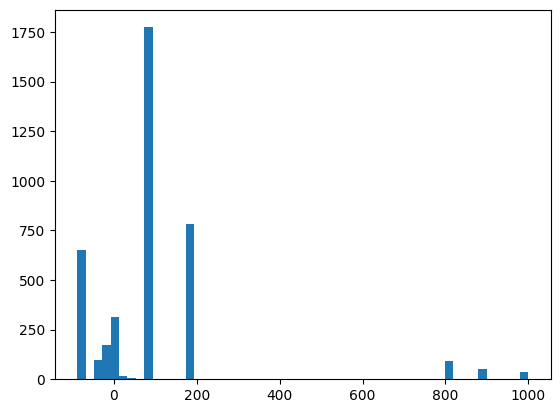

In [41]:
pred_onehot = mod.predict(pred)
for i in range(5):
    print(f"Prediction: {decode_labels(pred_onehot[i])}, real: {decode_labels(y_text_onehot[test_idx[i]])}")

plt.hist([
    float(temp)
    if (temp:=(decode_labels(yeet)).strip()) not in ['', '-', '+']
    else 1000
    for yeet in pred_onehot
    ], bins=int(2*(20000)**(1/3)))

(3, 28, 28)


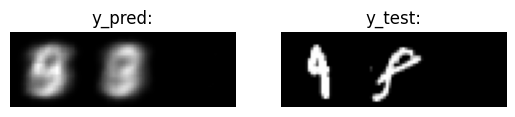

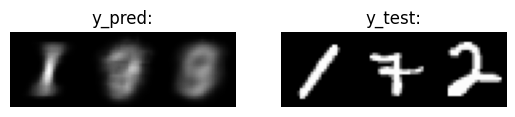

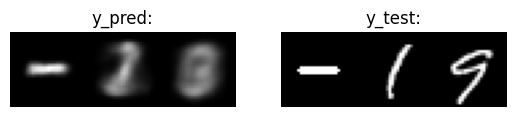

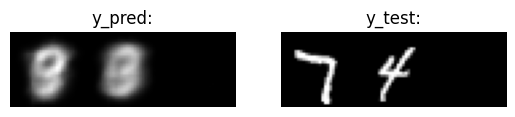

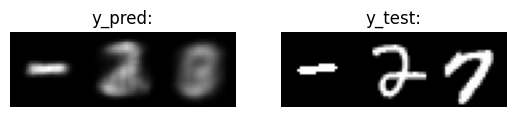

In [25]:
def display_sample_prediction(n):
    labels = ['y_pred:', 'y_test:']
    for j, data in enumerate([pred, y_test]):
        plt.subplot(1,2,j+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[j])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    # print('='*50, f'\nQuery #{n}\n\npred: "{X_text[n]}" = y_test: "{y_text[n]}"')
    plt.show()

# data = [pred,y_test]
print(pred[0].shape)
for i in range(5):
  display_sample_prediction(i)

# print(np.max(pred[0]-pred[2300]))
# # print(pred[1])


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

In [ ]:
'''
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is '100*100'='10000')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])
'''

'\n# Illustrate the generated query/answer pairs\n\nunique_characters = \'0123456789* \'       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character \' \'.)\nhighest_integer = 99                      # Highest value of integers contained in the queries\n\nmax_int_length = len(str(highest_integer))# Maximum number of characters in an integer\nmax_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. \'22+10\'])\nmax_answer_length = 5    # Maximum length of the answer string (the longest resulting query string is \'100*100\'=\'10000\')\n\n# Create the data (might take around a minute)\n(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()\nX_text, X_img, y_text, y_img = create_data(highest_integer, operands=[\'*\'])\nprint(X_text.shape, X_img.shape, y_text.shape, y_img.shape)\n\n\n## Display the samples that were created\ndef display_sample(n

In [ ]:
## Your code










